In [1]:
import tensorflow as tf
import os
import time
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
from nilearn import image
from nilearn import plotting
import nibabel as nib
from nilearn.plotting import plot_stat_map, plot_anat, plot_img

/localhome/mkhademi/anaconda3/envs/tf/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
data_dir = '/local-scratch/localhome/mkhademi/BOLD5000_2.0/'
batch_size = 20
dataset = tf.data.TFRecordDataset(filenames = [data_dir + 'image_data/bold5000_coco.tfrecords']).batch(batch_size)
train_ds = dataset.take(1800//batch_size)
test_ds = dataset.skip(1800//batch_size)
test_ds = test_ds.take(200//batch_size)
train_ds = train_ds.shuffle(1800)

In [3]:
def tf_parse(eg):
    example = tf.io.parse_example(
        eg, {
            'x': tf.io.FixedLenFeature(shape=(71, 89, 72, 1), dtype=tf.float32),
            'y': tf.io.FixedLenFeature(shape=(1000), dtype=tf.float32),
            'y_coco': tf.io.FixedLenFeature(shape=(90), dtype=tf.int64),
            'y_imagenet': tf.io.FixedLenFeature(shape=(1000), dtype=tf.int64),
            'y_super': tf.io.FixedLenFeature(shape=(12), dtype=tf.int64),
            'y_common': tf.io.FixedLenFeature(shape=(90+12), dtype=tf.int64),
            'y_face': tf.io.FixedLenFeature(shape=(2), dtype=tf.int64),
        })
    return example['x'], example['y_face']
    
decoded = train_ds.map(tf_parse)
decoded_test = test_ds.map(tf_parse)

In [4]:
raw_example = next(iter(test_ds))
print(tf_parse(raw_example)[0].numpy().shape)
print(tf_parse(raw_example)[1].numpy().shape)
print(tf_parse(raw_example)[1].numpy().sum(axis=1))

(20, 71, 89, 72, 1)
(20, 2)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [5]:
for x_batch, y_batch in decoded_test.take(1):
    print(x_batch, y_batch)

tf.Tensor(
[[[[[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   ...

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]]


  [[[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   ...

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]]


  [[[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   ...

 

In [6]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(71, 89, 72, 1)),
    tf.keras.layers.Conv3D(1, 3, activation='relu', padding='same', name='conv1'),
    # tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(2, 3, padding='same', name='conv2'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(4, 3, padding='same', name='conv3'),
    # tf.keras.layers.Conv3D(2, 3, activation='relu', padding='same', name='conv3'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.5),
    # tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(2),
    # tf.keras.layers.Softmax()
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 71, 89, 72, 1)     28        
_________________________________________________________________
conv2 (Conv3D)               (None, 71, 89, 72, 2)     56        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 35, 44, 36, 2)     0         
_________________________________________________________________
conv3 (Conv3D)               (None, 35, 44, 36, 4)     220       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 17, 22, 18, 4)     0         
_________________________________________________________________
flatten (Flatten)            (None, 26928)             0         
_________________________________________________________________
dropout (Dropout)            (None, 26928)             0

In [7]:
model.compile(
    # loss='mse',
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    # loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    # optimizer=keras.optimizers.RMSprop(),
    optimizer='adam',
    # metrics=[tf.keras.metrics.MeanSquaredError()],
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
    # metrics=[tf.keras.metrics.CategoricalCrossentropy(from_logits=True)]
)
model.fit(decoded, epochs=60)

Epoch 1/60
90/90 [==============================] - 16s 131ms/step - loss: 99.3910 - categorical_accuracy: 0.6067
Epoch 2/60
90/90 [==============================] - 14s 131ms/step - loss: 35.9545 - categorical_accuracy: 0.6583
Epoch 3/60
90/90 [==============================] - 14s 131ms/step - loss: 33.9415 - categorical_accuracy: 0.6667
Epoch 4/60
90/90 [==============================] - 14s 132ms/step - loss: 31.6664 - categorical_accuracy: 0.6839
Epoch 5/60
90/90 [==============================] - 14s 133ms/step - loss: 19.8323 - categorical_accuracy: 0.6828
Epoch 6/60
90/90 [==============================] - 14s 133ms/step - loss: 14.8208 - categorical_accuracy: 0.7289
Epoch 7/60
90/90 [==============================] - 14s 133ms/step - loss: 10.6768 - categorical_accuracy: 0.7156
Epoch 8/60
90/90 [==============================] - 14s 134ms/step - loss: 11.3643 - categorical_accuracy: 0.7250
Epoch 9/60
90/90 [==============================] - 15s 139ms/step - loss: 11.8771 - cat

/localhome/mkhademi/anaconda3/envs/tf/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


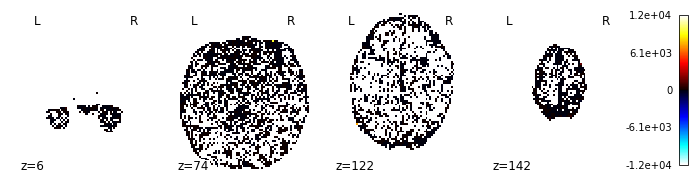

In [8]:
img4d = image.load_img(data_dir + 'CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-01.nii.gz');
selected_volumes = image.index_img(img4d, slice(200, 201))
imgs = [img for img in image.iter_img(selected_volumes)]
img = imgs[0]
mask = np.zeros(img.shape) * image.get_data(img)
plot_stat_map(img, threshold='auto', display_mode="z", cut_coords=4, bg_img=None)

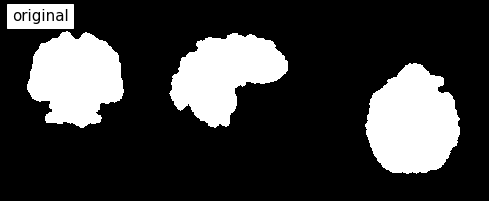

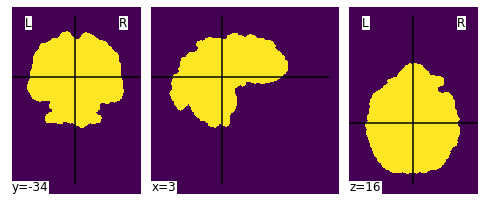

In [9]:
anat = '/local-scratch/localhome/mkhademi/ds001499/derivatives/fmriprep/sub-CSI1/anat/sub-CSI1_T1w_brainmask.nii.gz'   
plot_anat(anat, title='original', display_mode='ortho', dim=-1, draw_cross=False, annotate=False)
plot_img(anat)

In [10]:
img = np.array(img.dataobj)
print(np.max(img))
print(np.min(img))

9611.976
-12267.824


In [11]:
vis_output = model.get_layer('conv1').output
print(vis_output.shape)
vis_model = tf.keras.models.Model(inputs=model.input, outputs=vis_output)
vis_face = np.zeros(vis_output.shape[1:4])
vis_noface = np.zeros(vis_output.shape[1:4])
count_face = 0
count_noface = 0
for x_batch, y_batch in decoded:
    output = vis_model.predict(x_batch)
    for i in range(y_batch.shape[0]):
        if y_batch[i][0] == 1:
            vis_face += output[i].reshape(vis_output.shape[1:4]) 
            count_face += 1
        else:
            vis_noface += output[i].reshape(vis_output.shape[1:4])
            count_noface += 1
                      
print(count_face)
print(count_noface)
vis_face = vis_face/count_face 
vis_noface = vis_noface/count_noface 
print(vis_face) 
print(np.max(vis_face))
print(np.min(vis_face))

(None, 71, 89, 72, 1)
470
1330
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0

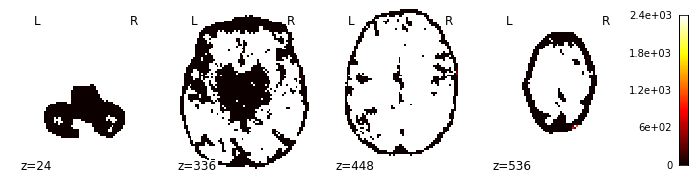

In [12]:
vis_face += mask
vis_noface += mask
nifti_file = nib.nifti1.Nifti1Image(dataobj=vis_face, affine=8*np.eye(4), header=None, extra=None, file_map=None)
plot_stat_map(nifti_file, threshold='auto', display_mode="z", cut_coords=4, bg_img=None)

In [13]:
loss, accuracy = model.evaluate(decoded_test)

10/10 [==============================] - 4s 47ms/step - loss: 0.6010 - categorical_accuracy: 0.8550


In [14]:
model.add(tf.keras.layers.Softmax())
for x_batch, y_batch in decoded_test.take(1):
    print(model(x_batch))
pos = 0
neg = 0
for x_batch, y_batch in decoded_test:
    for i in range(y_batch.shape[0]):
        if y_batch[i][0] == 1:
            pos += 1
        else:
            neg += 1
print(pos)
print(neg)

tf.Tensor(
[[2.4334426e-05 9.9997568e-01]
 [9.6475286e-03 9.9035245e-01]
 [9.9929893e-01 7.0101337e-04]
 [3.6258093e-01 6.3741904e-01]
 [7.2562434e-05 9.9992740e-01]
 [4.8827715e-02 9.5117229e-01]
 [2.5017074e-01 7.4982923e-01]
 [8.9819252e-01 1.0180752e-01]
 [3.0294359e-01 6.9705641e-01]
 [3.3065346e-05 9.9996698e-01]
 [1.8290882e-03 9.9817085e-01]
 [1.0658407e-03 9.9893421e-01]
 [9.2241930e-07 9.9999905e-01]
 [9.4151992e-01 5.8480095e-02]
 [7.0859189e-04 9.9929142e-01]
 [1.7049935e-03 9.9829501e-01]
 [7.6547080e-01 2.3452912e-01]
 [5.5348969e-06 9.9999452e-01]
 [4.6344842e-03 9.9536550e-01]
 [1.4070255e-05 9.9998593e-01]], shape=(20, 2), dtype=float32)
50
150


In [15]:
batch_size = 20
dataset = tf.data.TFRecordDataset(filenames = [data_dir + 'image_data/bold5000_common.tfrecords']).batch(batch_size)
train_ds = dataset.take((2135+400)//batch_size)
test_ds = dataset.skip((2135+400)//batch_size)
test_ds = test_ds.take(329//batch_size)
train_ds = train_ds.shuffle(2135+400)

In [16]:
def tf_parse(eg):
    example = tf.io.parse_example(
        eg, {
            'x': tf.io.FixedLenFeature(shape=(71, 89, 72, 1), dtype=tf.float32),
            'y': tf.io.FixedLenFeature(shape=(1000), dtype=tf.float32),
            'y_coco': tf.io.FixedLenFeature(shape=(90), dtype=tf.int64),
            'y_imagenet': tf.io.FixedLenFeature(shape=(1000), dtype=tf.int64),
            'y_super': tf.io.FixedLenFeature(shape=(12), dtype=tf.int64),
            'y_common': tf.io.FixedLenFeature(shape=(90+12), dtype=tf.int64),
            'y_face': tf.io.FixedLenFeature(shape=(2), dtype=tf.int64),
        })
    return example['x'], example['y_super']
    
decoded = train_ds.map(tf_parse)
decoded_test = test_ds.map(tf_parse)

In [17]:
raw_example = next(iter(test_ds))
print(tf_parse(raw_example)[0].numpy().shape)
print(tf_parse(raw_example)[1].numpy().shape)
print(tf_parse(raw_example)[1].numpy().sum(axis=1))

(20, 71, 89, 72, 1)
(20, 12)
[1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1]


In [18]:
for x_batch, y_batch in decoded_test.take(1):
    print(x_batch, y_batch)

tf.Tensor(
[[[[[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   ...

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]]


  [[[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   ...

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]]


  [[[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   [[0.]
    [0.]
    [0.]
    ...
    [0.]
    [0.]
    [0.]]

   ...

 

In [19]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(71, 89, 72, 1)),
    tf.keras.layers.Conv3D(1, 3, activation='relu', padding='same', name='conv1'),
    # tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(2, 3, padding='same', name='conv2'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(4, 3, padding='same', name='conv3'),
    # tf.keras.layers.Conv3D(2, 3, activation='relu', padding='same', name='conv3'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(12, activation='sigmoid'),
    # tf.keras.layers.Softmax()
    ])
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 71, 89, 72, 1)     28        
_________________________________________________________________
conv2 (Conv3D)               (None, 71, 89, 72, 2)     56        
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 35, 44, 36, 2)     0         
_________________________________________________________________
conv3 (Conv3D)               (None, 35, 44, 36, 4)     220       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 17, 22, 18, 4)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 26928)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 26928)            

In [20]:
model.compile(
    # loss='mse',
    # loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    # optimizer=keras.optimizers.RMSprop(),
    optimizer='adam',
    # metrics=[tf.keras.metrics.MeanSquaredError()],
    # metrics=[tf.keras.metrics.CategoricalAccuracy()],
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)
model.fit(decoded, epochs=60)

Epoch 1/60
126/126 [==============================] - 21s 133ms/step - loss: 23.0883 - binary_accuracy: 0.7733
Epoch 2/60
126/126 [==============================] - 20s 134ms/step - loss: 7.3278 - binary_accuracy: 0.7907
Epoch 3/60
126/126 [==============================] - 21s 141ms/step - loss: 4.0824 - binary_accuracy: 0.8037
Epoch 4/60
126/126 [==============================] - 21s 141ms/step - loss: 2.6843 - binary_accuracy: 0.8177
Epoch 5/60
126/126 [==============================] - 20s 137ms/step - loss: 1.8745 - binary_accuracy: 0.8285
Epoch 6/60
126/126 [==============================] - 20s 138ms/step - loss: 1.3525 - binary_accuracy: 0.8443
Epoch 7/60
126/126 [==============================] - 20s 138ms/step - loss: 1.5697 - binary_accuracy: 0.8507
Epoch 8/60
126/126 [==============================] - 20s 137ms/step - loss: 0.8920 - binary_accuracy: 0.8627
Epoch 9/60
126/126 [==============================] - 20s 137ms/step - loss: 0.8496 - binary_accuracy: 0.8690
Epoch 10/

In [21]:
loss, accuracy = model.evaluate(decoded_test)

16/16 [==============================] - 6s 48ms/step - loss: 0.6111 - binary_accuracy: 0.8474


In [22]:
for x_batch, y_batch in decoded_test.take(1):
    #print(tf.keras.activations.sigmoid(model(x_batch)))
    print(model(x_batch))

tf.Tensor(
[[2.60173324e-02 1.78735727e-03 8.25937459e-05 9.84520614e-01
  2.68408321e-02 4.87243593e-01 7.09405984e-04 1.48550334e-05
  2.67296145e-03 1.81068142e-04 4.26338914e-07 9.08199945e-06]
 [3.14755516e-06 9.34350956e-03 1.12941116e-03 6.25403374e-02
  6.76728014e-05 1.85876124e-04 4.71212089e-01 1.16270464e-02
  8.91852617e-01 3.02433282e-01 4.19611715e-05 1.69680116e-03]
 [1.30309351e-03 2.38508713e-02 8.60134489e-04 3.23131442e-01
  1.94990789e-04 3.61973391e-04 8.67911091e-04 4.23015701e-03
  1.62070617e-02 2.50673294e-02 3.26668669e-06 2.35906171e-07]
 [8.50328252e-06 2.47468233e-05 3.06526246e-03 9.55515265e-01
  5.60649914e-06 9.44275875e-04 2.96463728e-01 1.24794180e-02
  4.31744196e-02 1.39888871e-04 2.67393972e-07 5.24213056e-06]
 [1.26599101e-04 1.87870092e-03 1.80734714e-04 4.44648445e-01
  3.68607630e-06 6.10640878e-03 9.56290774e-03 1.28309464e-03
  4.35528129e-01 1.38984710e-01 1.21113108e-05 3.87161563e-04]
 [1.27179408e-02 1.44469410e-01 9.21671540e-02 4.59232